# Models - Inital Attempt
These were our initial models that were copied over into Models_Final.ipynb. These inital models yielded much lower success rates - verification was around %75, and our prediction model around %51. 

In [ ]:
!pip install global-land-mask
!pip install fastdtw
!pip install haversine

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [5]:
import os
import math
import random
from global_land_mask import globe
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import requests
from io import StringIO
from geopy.distance import geodesic
from haversine import haversine, Unit

import json
import random
import shutil
import statistics
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [5]:
#location spoofer
def calculate_bounding_box(center_lat, center_lon, radius_miles):
    return (
        geodesic().destination((center_lat, center_lon), 0, radius_miles).latitude,
        geodesic().destination((center_lat, center_lon), 90, radius_miles).longitude,
        geodesic().destination((center_lat, center_lon), 180, radius_miles).latitude,
        geodesic().destination((center_lat, center_lon), 270, radius_miles).longitude
    )
def get_random_point_within_bounding_box(bounding_box):
    random_lat = random.uniform(bounding_box[0], bounding_box[2])
    random_lon = random.uniform(bounding_box[1], bounding_box[3])
    return random_lat, random_lon

def get_points_within_radius(center_lat, center_lon, smaller_radius_miles, larger_radius_miles):
    smaller_bounding_box = calculate_bounding_box(center_lat, center_lon, smaller_radius_miles)
    larger_bounding_box = calculate_bounding_box(center_lat, center_lon, larger_radius_miles)

    random_point_within_larger_box = get_random_point_within_bounding_box(larger_bounding_box)

    while (
        smaller_bounding_box[0] <= random_point_within_larger_box[0] <= smaller_bounding_box[2] and
        smaller_bounding_box[1] <= random_point_within_larger_box[1] <= smaller_bounding_box[3]
    ):
        random_point_within_larger_box = get_random_point_within_bounding_box(larger_bounding_box)

    return random_point_within_larger_box

def spoof_location(center_lat, center_lon, smaller_radius_miles, larger_radius_miles):
    for i in range(10):
      lat_spoof, lon_spoof = get_points_within_radius(center_lat, center_lon, smaller_radius_miles, larger_radius_miles)
      if globe.is_land(lat_spoof, lon_spoof):
        return (lat_spoof, lon_spoof)
    return get_points_within_radius(center_lat, center_lon, smaller_radius_miles, larger_radius_miles)

In [ ]:
# center_lat = 42.7284
# center_lon = -73.6918
# smaller_radius_miles = 50
# larger_radius_miles = 400

# for ix in range(5) :
#   result = spoof_location(center_lat, center_lon, smaller_radius_miles, larger_radius_miles)
#   print(f"Count {ix+1} ----> Latitude : {result[0]:.5f} ----> Longitude : {result[1]:.5f}")

# import folium

# latitude = 25.47
# longitude = -112.58


# lon2 = -67.19
# lat2 = 48.94

# lon3 = -82.39
# lat3 = 27.28

# map_center1 = [latitude, longitude]
# map_center2 = [lat2, lon2]
# map_center3 = [lat3, lon3]
# my_map = folium.Map(location=map_center1, zoom_start=10)
# my_map = folium.Map(location=map_center2, zoom_start=10)
# my_map = folium.Map(location=map_center3, zoom_start=10)
# folium.Marker(location=map_center1, popup="Given Location").add_to(my_map)
# folium.Marker(location=map_center2, popup="Given Location").add_to(my_map)
# folium.Marker(location=map_center3, popup="Given Location").add_to(my_map)

# my_map


In [56]:
#dataset and model classes for verification model

class TreeRingDataset(Dataset):

  _cache = None
  _train = None
  _test = None
  _validate = None

  def __init__(self, set_type="train"):

    if TreeRingDataset._cache is None:
      res = requests.get("https://paleo-data.s3.amazonaws.com/data.csv")
      TreeRingDataset._cache = pd.read_csv(StringIO(res.text), sep=",")

    res = requests.get("https://paleo-data.s3.amazonaws.com/main_weather.csv")
    self.W_df = pd.read_csv(StringIO(res.text), sep=",")
    self.W_df.drop_duplicates(subset = ['year', 'lat', 'lon'],
                                          inplace = True,
                                          ignore_index = True)

    self.df = TreeRingDataset._cache.copy()

    self.df.drop(self.df.columns[list(range(1, 1940))], axis=1, inplace=True)
    self.df.dropna(subset=self.df.columns[1:52], how='any', inplace=True)

    if type(TreeRingDataset._train) == type(None):
      print("Performing a Split")
      TreeRingDataset._train, TreeRingDataset._test, TreeRingDataset._validate = self.__split()

    self.df = TreeRingDataset._train if set_type == "train" else (TreeRingDataset._test if set_type == "test" else TreeRingDataset._validate)

  def __split(self):
    train, test = train_test_split(self.df, train_size=.70)
    validate, test = train_test_split(test, train_size=.5)
    return (train, test, validate)

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, index):
    x = torch.tensor(self.df.iloc[index, 1:52].ffill().bfill())
    latn, lats, lone, lonw = self.df.iloc[index, 87:91]
    # lat = (latn+lats)/2
    # lon = (lone+lonw)/2
    lat = latn
    lon = lone

    #print(lat, lon)

    if random.random() > 0.5:
      other_locations = self.W_df[['lat','lon']][(self.W_df['lat'] != lat) & (self.W_df['lon'] != lon)]
      unique_locations = other_locations.drop_duplicates()
      spoof_location = unique_locations.sample(n=1)
      label = 0
      lat = spoof_location['lat'].iloc[0]
      lon = spoof_location['lon'].iloc[0]

    else:
      label = 1

    #print(lat, lon)


    weather_data = self.W_df[(self.W_df['lat'] == lat) & (self.W_df['lon'] == lon)]

    temp = torch.tensor(weather_data['temperature_avg'].values)
    precip = torch.tensor(weather_data['precipitation_avg'].values)
    x = torch.cat((x, temp, precip))
    #print(x.shape)

    return x, label

class VerificationModel(nn.Module):
  def __init__(self, num_rings):
      super(VerificationModel, self).__init__()
      self.fc = nn.Sequential(
          nn.Linear(num_rings * 3, 512),
          nn.ReLU(),
          nn.Linear(512, 512),
          nn.ReLU(),
          nn.Linear(512, 512),
          nn.ReLU(),
          nn.Linear(512, 256),
          nn.ReLU(),
          nn.Linear(256, 1),
          nn.Sigmoid()
      )

  def forward(self, x):
      out = self.fc(x)
      return out

In [44]:
#dataset and model classes for location  model

class TreeRingDataset(Dataset):

  _cache = None
  _train = None
  _test = None
  _validate = None

  def __init__(self, set_type="train"):

    if TreeRingDataset._cache is None:
      res = requests.get("https://paleo-data.s3.amazonaws.com/data.csv")
      TreeRingDataset._cache = pd.read_csv(StringIO(res.text), sep=",")

    self.df = TreeRingDataset._cache.copy()

    self.df.drop(self.df.columns[list(range(1, 1940))], axis=1, inplace=True)
    self.df.dropna(subset=self.df.columns[1:52], how='any', inplace=True)

    if type(TreeRingDataset._train) == type(None):
      print("Performing a Split")
      TreeRingDataset._train, TreeRingDataset._test, TreeRingDataset._validate = self.__split()

    self.df = TreeRingDataset._train if set_type == "train" else (TreeRingDataset._test if set_type == "test" else TreeRingDataset._validate)


  def __split(self):
    train, test = train_test_split(self.df, train_size=.70)
    validate, test = train_test_split(test, train_size=.5)
    return (train, test, validate)

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, index):
    x = torch.tensor(self.df.iloc[index, 1:52])
    latn, lats, lone, lonw = self.df.iloc[index, 87:91]
    label = torch.tensor([(latn+lats)/2, (lone+lonw)/2])
    return x, label

class LocationModel(nn.Module):
  def __init__(self, num_rings):
      super(LocationModel, self).__init__()
      self.fc = nn.Sequential(
          nn.Linear(num_rings, 256),
          nn.ReLU(),
          nn.Linear(256, 256),
          nn.ReLU(),
          nn.Linear(256, 256),
          nn.ReLU(),
          nn.Linear(256, 256),
          nn.ReLU(),
          nn.Linear(256, 256),
          nn.ReLU(),
          nn.Linear(256, 2),
      )

  def forward(self, x):
      out = self.fc(x)
      return out

In [ ]:
#Dataset and Dataloader calls
train_dataset = TreeRingDataset(set_type= "train")
print(train_dataset.__getitem__(5))
val_dataset = TreeRingDataset(set_type= "validate")
test_dataset = TreeRingDataset(set_type= "test")


train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_data_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [12]:
#calculates climate comparison
def climate_comparison(ts1, ts2):
  distance, path = fastdtw(ts1, ts2, dist=euclidean)
  return(distance)

#input is a tuple with lat and lon and a tuple with start and end year,
#outputs a vector of temperatures over that time period
def get_temp(lat_lon, years):
  return 0

#input is a tuple with lat and lon and a tuple with start and end year,
#outputs a vector of precipitation values over that time period
def get_precip(lat_lon):
  return 0


def clip_coords(lat_lon):
  lat, lon = lat_lon
  return (math.fmod(lat, 90), math.fmod(lon, 180))

def climate_loss(output, target):
  output = clip_coords(output)
  ts_temp_output = get_temp(output)
  ts_precip_output = get_precip(output)
  ts_temp_target = get_temp(target)
  ts_precip_target = get_precip(target)

  temp_dtw = climate_comparison(ts_temp_output, ts_temp_target)
  precip_dtw = climate_comparison(ts_precip_output, ts_precip_target)
  return (output[0] - target[0])**2 + (target[1] - target[1])**2 + (temp_dtw * precip_dtw)


(10.728399999999993, -3.6918000000000006)


In [ ]:
#location model training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


#model = VerificationModel(51).to(device)
model = LocationModel(51).to(device)

loss_function = climate_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Define the number of epochs for training
num_epochs = 50

# Get the total number of training samples
training_size = len(train_data_loader.dataset)

for epoch in range(num_epochs):
    print("Epoch", epoch+1, "\n---------------------")

    # Set the model to training mode
    model.train()
    running_loss = 0.0
    training_batch = 0

    # Iterate over training batches
    for inputs, labels in train_data_loader:
        # Move inputs and labels to the specified device
        inputs = inputs.float()
        # print(inputs[0])

        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass to get outputs

        outputs = model(inputs)

        # Calculate the loss
        outputs = outputs.view(-1)

        labels = labels.float()
        loss = loss_function(outputs, labels)


        # Backward pass to calculate gradients
        loss.backward()
        # Update weights
        optimizer.step()


        # Update running loss and batch count
        running_loss += loss.item() * inputs.size(0)
        training_batch += len(inputs)
        print(f"training loss: {loss:>7f}  Batch: [{training_batch:>5d}/{training_size:>5d}]")

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_data_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    # Validation phase
    model.eval()
    validation_loss = 0.0
    total_distances = 0
    validation_size = len(validation_data_loader.dataset)

    with torch.no_grad():
        validation_batch = 0
        for inputs, labels in validation_data_loader:
            # Move inputs and labels to the specified device
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.float()
            # Forward pass
            outputs = model(inputs)
            # outputs = outputs.view(-1)

            labels = labels.float()

            # Calculate loss
            loss = loss_function(outputs, labels)

            # Update validation loss and count
            validation_loss += loss.item() * inputs.size(0)
            # Calculate accuracy
            total_distances += haversine((outputs[0], outputs[1]),(labels[0], labels[1]))

            print(f"validation loss: {loss:>7f}  Batch: [{validation_batch:>5d}/{validation_size:>5d}]")

    # Calculate average validation loss and accuracy for the epoch
    epoch_validation_loss = validation_loss / len(validation_data_loader.dataset)
    validation_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {epoch_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%\n\n")



In [58]:
#verification Model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


model = VerificationModel(51).to(device)

loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Define the number of epochs for training
num_epochs = 50

# Get the total number of training samples
training_size = len(train_data_loader.dataset)

for epoch in range(num_epochs):
    print("Epoch", epoch+1, "\n---------------------")

    # Set the model to training mode
    model.train()
    running_loss = 0.0
    training_batch = 0

    # Iterate over training batches
    for inputs, labels in train_data_loader:

        # Move inputs and labels to the specified device
        inputs = inputs.float()
        # print(inputs.shape)
        # print(labels.shape)

        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass to get outputs

        outputs = model(inputs)

        # Calculate the loss
        outputs = outputs.view(-1)

        labels = labels.float()
        loss = loss_function(outputs, labels)


        # Backward pass to calculate gradients
        loss.backward()
        # Update weights
        optimizer.step()


        # Update running loss and batch count
        running_loss += loss.item() * inputs.size(0)
        training_batch += len(inputs)
        print(f"training loss: {loss:>7f}  Batch: [{training_batch:>5d}/{training_size:>5d}]")

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_data_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    # Validation phase
    model.eval()
    validation_loss = 0.0
    correct = 0
    total = 0
    validation_size = len(validation_data_loader.dataset)

    with torch.no_grad():
        validation_batch = 0
        for inputs, labels in validation_data_loader:
            # Move inputs and labels to the specified device
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.float()
            # Forward pass
            outputs = model(inputs)
            outputs = outputs.view(-1)

            labels = labels.float()

            # Calculate loss
            loss = loss_function(outputs, labels)

            # Update validation loss and count
            validation_loss += loss.item() * inputs.size(0)
            # Calculate accuracy
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            validation_batch += len(inputs)
            print(f"validation loss: {loss:>7f}  Batch: [{validation_batch:>5d}/{validation_size:>5d}]")

    # Calculate average validation loss and accuracy for the epoch
    epoch_validation_loss = validation_loss / len(validation_data_loader.dataset)
    validation_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {epoch_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%\n\n")



Using cpu device
Epoch 1 
---------------------
training loss: 0.672027  Batch: [   32/ 4992]
training loss: 0.692549  Batch: [   64/ 4992]
training loss: 0.702754  Batch: [   96/ 4992]
training loss: 0.755907  Batch: [  128/ 4992]
training loss: 0.745147  Batch: [  160/ 4992]
training loss: 0.671949  Batch: [  192/ 4992]
training loss: 0.696577  Batch: [  224/ 4992]
training loss: 0.702525  Batch: [  256/ 4992]
training loss: 0.699351  Batch: [  288/ 4992]
training loss: 0.695840  Batch: [  320/ 4992]
training loss: 0.688111  Batch: [  352/ 4992]
training loss: 0.703228  Batch: [  384/ 4992]
training loss: 0.699311  Batch: [  416/ 4992]
training loss: 0.697787  Batch: [  448/ 4992]
training loss: 0.718982  Batch: [  480/ 4992]
training loss: 0.668359  Batch: [  512/ 4992]
training loss: 0.687824  Batch: [  544/ 4992]
training loss: 0.696861  Batch: [  576/ 4992]
training loss: 0.687268  Batch: [  608/ 4992]
training loss: 0.685816  Batch: [  640/ 4992]
training loss: 0.690914  Batch: 

KeyboardInterrupt: ignored

Threshold: 0.3
Threshold: 0.325
Threshold: 0.35000000000000003
Threshold: 0.37500000000000006
Threshold: 0.4000000000000001
Threshold: 0.4250000000000001
Threshold: 0.4500000000000001
Threshold: 0.47500000000000014
Threshold: 0.5000000000000002
Threshold: 0.5250000000000001
Threshold: 0.5500000000000003
Threshold: 0.5750000000000002
Threshold: 0.6000000000000003
Threshold: 0.6250000000000002
Threshold: 0.6500000000000004
Threshold: 0.6750000000000003
Threshold: 0.7000000000000004
Threshold: 0.7250000000000003
Threshold: 0.7500000000000004
Threshold: 0.7750000000000004
Threshold: 0.8000000000000005


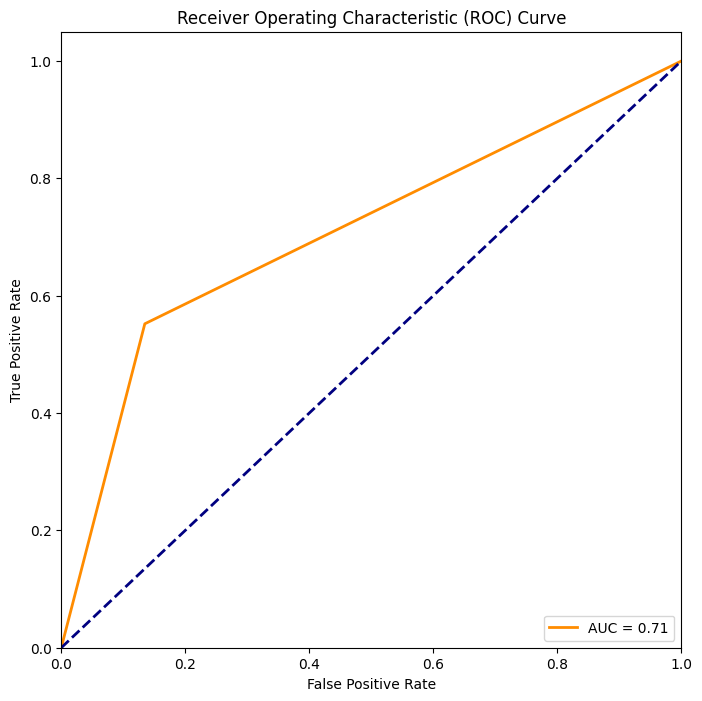

Test Loss: 0.0172, Test Accuracy: 51.96%
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0

In [77]:
from sklearn.metrics import roc_curve, auc
def test_model(threshold):
  # Set the model to evaluation mode
  model.eval()
  test_loss = 0.0
  correct = 0
  total = 0
  # Get the total number of testing samples
  testing_size = len(test_data_loader.dataset)
  predicted_class = []
  actual_class = []

  with torch.no_grad():
      training_batch = 0
      # Iterate over the test data
      for inputs, labels in test_data_loader:
          # Move inputs and labels to the specified device
          inputs, labels = inputs.to(device), labels.to(device)
          inputs = inputs.float()
          labels = labels.float()
          # Forward pass (with batch size of 1)
          outputs = model(inputs.unsqueeze(0))

          # Compute the loss
          loss = loss_function(outputs.squeeze(), labels)

          # Accumulate the test loss
          test_loss += loss.item()

          # Get the predicted class

          predicted = (outputs > threshold).float()

          total += labels.size(0)

          predicted = predicted.view(-1)
          correct += (predicted == labels).sum().item()

          # Store actual and predicted classes
          actual_class.extend(labels.tolist())
          predicted_class.extend(predicted.tolist())

          # Count correct predictions
          training_batch += len(inputs)
          #print(f"test loss: {loss:>7f}  Batch: [{training_batch:>5d}/{testing_size:>5d}]")
  return test_loss, correct, total, predicted_class, actual_class

all_predicted_probs = []
all_actual_labels = []
thresholds = np.arange(0.3, 0.8, 0.05)

for i in thresholds:
  print(f"Threshold: {i}")
  test_loss, correct, total, predicted_class, actual_class = test_model(i)
  conf_mat = confusion_matrix(actual_class, predicted_class)

fpr, tpr, thresholds_roc = roc_curve(all_actual_labels, all_predicted_probs)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Calculate final test loss using the total test dataset size
final_test_loss = test_loss / len(test_data_loader.dataset)

# Calculate the accuracy of the model on the test set
test_accuracy = 100 * correct / total

# Print out the final test loss and accuracy
print(f"Test Loss: {final_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

print(actual_class)
print(predicted_class)

# Compute the confusion matrix using the actual and predicted classes
conf_mat = confusion_matrix(actual_class, predicted_class)

# Print out the confusion matrix
print(conf_mat)